In [1]:
%%time 

# Installing select libraries:-
from gc import collect;
from warnings import filterwarnings;
filterwarnings('ignore');
from IPython.display import display_html, clear_output;

!pip install -q "/kaggle/input/pythonlibrarieswheelfiles/catboost-1.2.2-cp310-cp310-manylinux2014_x86_64.whl";
!pip install -q "/kaggle/input/pythonlibrarieswheelfiles/lightgbm-4.2.0-py3-none-manylinux_2_28_x86_64.whl";
!pip install -q "/kaggle/input/pythonlibrarieswheelfiles/pandas-2.1.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl";
!pip install -q "/kaggle/input/pythonlibrarieswheelfiles/scikit_learn-1.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl";
!pip install -q "/kaggle/input/pythonlibrarieswheelfiles/xgboost-2.0.2-py3-none-manylinux2014_x86_64.whl";
clear_output();

import xgboost as xgb, lightgbm as lgb, catboost as cb, sklearn as sk, pandas as pd;
print(f"---> XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | Catboost = {cb.__version__}");
print(f"---> Sklearn = {sk.__version__}| Pandas = {pd.__version__}\n\n");
collect();

---> XGBoost = 2.0.2 | LightGBM = 4.2.0 | Catboost = 1.2.2
---> Sklearn = 1.4.0| Pandas = 2.2.0


CPU times: user 4.13 s, sys: 479 ms, total: 4.61 s
Wall time: 1min 19s


In [2]:
%%time

# General library imports:-
from copy import deepcopy;
import pandas as pd;
import numpy as np;
import re;
from scipy.stats import mode, kstest, normaltest, shapiro, anderson, jarque_bera;
from collections import Counter;
from itertools import product;
from colorama import Fore, Style, init;
from warnings import filterwarnings;
filterwarnings('ignore');
import joblib;
import os;

from tqdm.notebook import tqdm;
import seaborn as sns;
import matplotlib.pyplot as plt;
from matplotlib.colors import ListedColormap as LCM;
%matplotlib inline

from pprint import pprint;
from functools import partial;

print();
collect();
clear_output();

CPU times: user 139 ms, sys: 15.8 ms, total: 155 ms
Wall time: 180 ms


In [3]:
%%time 

# Importing model and pipeline specifics:-
from category_encoders import OrdinalEncoder, OneHotEncoder;

# Pipeline specifics:-
from sklearn.preprocessing import (RobustScaler, 
                                   MinMaxScaler, 
                                   StandardScaler, 
                                   FunctionTransformer as FT,
                                   PowerTransformer,
                                  );
from sklearn.impute import SimpleImputer as SI;
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
                                     StratifiedKFold as SKF,
                                     KFold, 
                                     RepeatedKFold as RKF, 
                                     cross_val_score, cross_val_predict
                                    );
from sklearn.inspection import permutation_importance;
from sklearn.feature_selection import mutual_info_classif, RFE;
from sklearn.pipeline import Pipeline, make_pipeline;
from sklearn.base import BaseEstimator, TransformerMixin;
from sklearn.compose import ColumnTransformer;

# ML Model training:-
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer;
from xgboost import DMatrix, XGBClassifier as XGBC;
from lightgbm import log_evaluation, early_stopping, LGBMClassifier as LGBMC;
from catboost import CatBoostClassifier as CBC, Pool;

# Ensemble and tuning:-
import optuna;
from optuna import Trial, trial, create_study;
from optuna.pruners import HyperbandPruner;
from optuna.samplers import TPESampler, CmaEsSampler;
optuna.logging.set_verbosity = optuna.logging.ERROR;

clear_output();
print();
collect();


CPU times: user 440 ms, sys: 32.9 ms, total: 473 ms
Wall time: 541 ms


In [4]:
%%time 

# Setting rc parameters in seaborn for plots and graphs- 
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        });

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 

# Making sklearn pipeline outputs as dataframe:-
from sklearn import set_config; 
set_config(transform_output = "pandas");
pd.set_option('display.max_columns', 50);
pd.set_option('display.max_rows', 50);

print();
collect();


CPU times: user 122 ms, sys: 0 ns, total: 122 ms
Wall time: 121 ms


In [5]:
%%time

# Configuration class:-
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;
    
    # Data preparation:-   
    version_nb         = 1;
    test_req           = "N";
    test_sample_frac   = 0.025;
    gpu_switch         = "OFF"; 
    state              = 42;
    target             = 'NObeyesdad';
    episode            = 2;
    season             = 4;
    path               = f"/kaggle/input/playground-series-s{season}e{episode}";
    orig_path          = f"/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv";
    
    dtl_preproc_req    = "Y";
    adv_cv_req         = "N";
    ftre_plots_req     = 'Y';
    ftre_imp_req       = "Y";
    
    # Data transforms and scaling:-    
    conjoin_orig_data  = "Y";
    drop_nulls         = "N";
    sec_ftre_req       = "Y";
    scale_req          = "N";
    # NOTE---Keep a value here even if scale_req = N, this is used for linear models:-
    scl_method         = "Z"; 
    enc_method         = 'Label';
    OH_cols            = ["CAEC", "CALC", "MTRANS"];
    tgt_mapper         = {'Insufficient_Weight'  : 0,
                          'Normal_Weight'        : 1,
                          'Overweight_Level_I'   : 2,
                          'Overweight_Level_II'  : 3,
                          'Obesity_Type_I'       : 4,
                          'Obesity_Type_II'      : 5,
                          'Obesity_Type_III'     : 6,    
                         };

    # Model Training:- 
    baseline_req       = "N";
    pstprcs_oof        = "N";
    pstprcs_train      = "N";
    pstprcs_test       = "N";
    ML                 = "Y";
    
    pseudo_lbl_req     = "N";
    pseudolbl_up       = 0.975;
    pseudolbl_low      = 0.00;
    
    use_orig_allfolds  = "N";
    n_splits           = 3 if test_req == "Y" else 5;
    n_repeats          = 1 ;
    nbrnd_erly_stp     = 65;
    mdlcv_mthd         = 'RSKF';
    
    # Ensemble:-    
    ensemble_req       = "Y";
    hill_climb_req     = "N";
    optuna_req         = "Y";
    LAD_req            = "N";
    enscv_mthd         = "RSKF";
    metric_obj         = 'maximize';
    ntrials            = 10 if test_req == "Y" else 150;
    
    # Global variables for plotting:-
    grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--', 
                           'color': 'lightgrey', 'linewidth': 0.75};
    title_specs = {'fontsize': 9, 'fontweight': 'bold', 'color': 'tab:blue'};

print();
PrintColor(f"--> Configuration done!\n");
collect();


--> Configuration done!

CPU times: user 117 ms, sys: 0 ns, total: 117 ms
Wall time: 117 ms


In [6]:
%%time 

# Defining functions to be used throughout the code for common tasks:-

# Scaler to be used for continuous columns:- 
all_scalers = {'Robust': RobustScaler(), 
               'Z': StandardScaler(), 
               'MinMax': MinMaxScaler(),
               "PT" : PowerTransformer(),
              };
scaler      = all_scalers.get(CFG.scl_method);

# Making a directory to store the model objects:-
if os.path.exists("/kaggle/working/MLModels") == True:
    PrintColor(f"\n---> MLModels already exists\n", color = Fore.RED);
else:
    os.mkdir("MLModels");
    PrintColor(f"\n---> Made directory MLModels to store models for inference\n", color = Fore.RED)


collect();
print();


---> Made directory MLModels to store models for inference


CPU times: user 119 ms, sys: 0 ns, total: 119 ms
Wall time: 118 ms


In [7]:
%time 

class Preprocessor():
    """
    This class aims to do the below-
    1. Read the datasets
    2. In this case, process the original data
    3. Check information and description
    4. Check unique values and nulls
    5. Collate starting features 
    6. Conjoin train-original data if requested based on Adversarial CV results
    """;
    
    def __init__(self):
        self.train             = pd.read_csv(os.path.join(CFG.path,"train.csv"), index_col = 'id');
        self.test              = pd.read_csv(os.path.join(CFG.path ,"test.csv"), index_col = 'id');
        self.target            = CFG.target ;
        self.original          = pd.read_csv(CFG.orig_path);
        self.conjoin_orig_data = CFG.conjoin_orig_data;
        self.dtl_preproc_req   = CFG.dtl_preproc_req;
        self.test_req          = CFG.test_req;
        
        self.sub_fl   = pd.read_csv(os.path.join(CFG.path, "sample_submission.csv"));
        PrintColor(f"Data shapes - train-test-original | {self.train.shape} {self.test.shape} {self.original.shape}");
        
        for tbl in [self.train, self.original, self.test]:
            tbl.columns = tbl.columns.str.replace(r"\(|\)|\s+","", regex = True);
            
        PrintColor(f"\nTrain set head", color = Fore.CYAN);
        display(self.train.head(5).style.format(precision = 3));
        PrintColor(f"\nTest set head", color = Fore.CYAN);
        display(self.test.head(5).style.format(precision = 3));
        PrintColor(f"\nOriginal set head", color = Fore.CYAN);
        display(self.original.head(5).style.format(precision = 3));
                 
        # Resetting original data index:-
        self.original.index = range(len(self.original));
        self.original.index+= max(self.test.index) + 1;
        self.original.index.name = 'id';
        
        #  Changing original data column order to match the competition column structure:-
        self.original = self.original.reindex(self.train.columns, axis=1);
              
    def _AddSourceCol(self):
        self.train['Source']    = "Competition";
        self.test['Source']     = "Competition";
        self.original['Source'] = 'Original';
        
        self.strt_ftre = self.test.columns;
        return self;
          
    def _CollateInfoDesc(self):
        if self.dtl_preproc_req == "Y":
            PrintColor(f"\n{'-'*20} Information and description {'-'*20}\n", color = Fore.MAGENTA);

            # Creating dataset information and description:
            for lbl, df in {'Train': self.train, 'Test': self.test, 'Original': self.original}.items():
                PrintColor(f"\n{lbl} description\n");
                display(df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).\
                        transpose().\
                        drop(columns = ['count'], errors = 'ignore').\
                        drop([CFG.target], axis=0, errors = 'ignore').\
                        style.format(formatter = '{:,.2f}').\
                        background_gradient(cmap = 'Blues')
                       );

                PrintColor(f"\n{lbl} information\n");
                display(df.info());
                collect();
        return self;
    
    def _CollateUnqNull(self):
        
        if self.dtl_preproc_req == "Y":
            # Dislaying the unique values across train-test-original:-
            PrintColor(f"\nUnique and null values\n");
            _ = pd.concat([self.train[self.strt_ftre].nunique(), 
                           self.test[self.strt_ftre].nunique(), 
                           self.original[self.strt_ftre].nunique(),
                           self.train[self.strt_ftre].isna().sum(axis=0),
                           self.test[self.strt_ftre].isna().sum(axis=0),
                           self.original[self.strt_ftre].isna().sum(axis=0)
                          ], 
                          axis=1);
            _.columns = ['Train_Nunq', 'Test_Nunq', 'Original_Nunq', 
                         'Train_Nulls', 'Test_Nulls', 'Original_Nulls'
                        ];

            display(_.T.style.background_gradient(cmap = 'Blues', axis=1).\
                    format(formatter = '{:,.0f}')
                   );
            
        return self;
       
    def DoPreprocessing(self):
        self._AddSourceCol();
        self._CollateInfoDesc();
        self._CollateUnqNull();
        
        return self; 
        
    def ConjoinTrainOrig(self):
        if self.conjoin_orig_data == "Y":
            PrintColor(f"Train shape before conjoining with original = {self.train.shape}");
            train = pd.concat([self.train, self.original], axis=0, ignore_index = True);
            PrintColor(f"Train shape after conjoining with original= {train.shape}");
            
            train = train.drop_duplicates();
            PrintColor(f"Train shape after de-duping = {train.shape}");
            
            train.index = range(len(train));
            train.index.name = 'id';
        
        else:
            PrintColor(f"We are using the competition training data only");
            train = self.train;
        return train;
          
collect();
print();

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs



In [8]:
%%time 

pp = Preprocessor();
pp.DoPreprocessing();

print();
collect();

Data shapes - train-test-original | (20758, 17) (13840, 16) (2111, 17)

Train set head


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443,1.700,81.670,yes,yes,2.000,2.983,Sometimes,no,2.764,no,0.000,0.976,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000,1.560,57.000,yes,yes,2.000,3.000,Frequently,no,2.000,no,1.000,1.000,no,Automobile,Normal_Weight
2,Female,18.000,1.711,50.166,yes,yes,1.881,1.412,Sometimes,no,1.910,no,0.866,1.674,no,Public_Transportation,Insufficient_Weight
3,Female,20.953,1.711,131.275,yes,yes,3.000,3.000,Sometimes,no,1.674,no,1.468,0.780,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641,1.914,93.798,yes,yes,2.680,1.971,Sometimes,no,1.980,no,1.968,0.932,Sometimes,Public_Transportation,Overweight_Level_II



Test set head


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
20758,Male,26.900,1.848,120.644,yes,yes,2.939,3.000,Sometimes,no,2.826,no,0.855,0.000,Sometimes,Public_Transportation
20759,Female,21.000,1.600,66.000,yes,yes,2.000,1.000,Sometimes,no,3.000,no,1.000,0.000,Sometimes,Public_Transportation
20760,Female,26.000,1.643,111.601,yes,yes,3.000,3.000,Sometimes,no,2.622,no,0.000,0.251,Sometimes,Public_Transportation
20761,Male,20.979,1.553,103.669,yes,yes,2.000,2.978,Sometimes,no,2.786,no,0.095,0.000,Sometimes,Public_Transportation
20762,Female,26.000,1.627,104.835,yes,yes,3.000,3.000,Sometimes,no,2.654,no,0.000,0.741,Sometimes,Public_Transportation



Original set head


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000,1.620,64.000,yes,no,2.000,3.000,Sometimes,no,2.000,no,0.000,1.000,no,Public_Transportation,Normal_Weight
1,Female,21.000,1.520,56.000,yes,no,3.000,3.000,Sometimes,yes,3.000,yes,3.000,0.000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000,1.800,77.000,yes,no,2.000,3.000,Sometimes,no,2.000,no,2.000,1.000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000,1.800,87.000,no,no,3.000,3.000,Sometimes,no,2.000,no,2.000,0.000,Frequently,Walking,Overweight_Level_I
4,Male,22.000,1.780,89.800,no,no,2.000,1.000,Sometimes,no,2.000,no,0.000,0.000,Sometimes,Public_Transportation,Overweight_Level_II



-------------------- Information and description --------------------


Train description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Age,23.84,5.69,14.00,17.99,20.00,22.82,26.00,31.39,35.46,41.00,61.00
Height,1.70,0.09,1.45,1.56,1.63,1.70,1.76,1.82,1.85,1.89,1.98
Weight,87.89,26.38,39.00,49.00,66.00,84.06,111.60,121.00,132.12,137.86,165.06
FCVC,2.45,0.53,1.00,1.83,2.00,2.39,3.00,3.00,3.00,3.00,3.00
NCP,2.76,0.71,1.00,1.00,3.00,3.00,3.00,3.00,3.52,4.00,4.00
CH2O,2.03,0.61,1.00,1.00,1.79,2.00,2.55,2.87,3.00,3.00,3.00
FAF,0.98,0.84,0.00,0.00,0.01,1.00,1.59,2.00,2.55,3.00,3.00
TUE,0.62,0.60,0.00,0.00,0.00,0.57,1.00,1.44,2.00,2.00,2.00



Train information

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF              

None


Test description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Age,23.95,5.80,14.00,18.00,20.00,22.91,26.00,31.74,37.06,41.68,61.00
Height,1.70,0.09,1.45,1.55,1.63,1.70,1.76,1.82,1.85,1.90,1.98
Weight,87.38,26.11,39.00,49.00,65.00,83.95,111.16,120.90,131.34,137.79,165.06
FCVC,2.44,0.53,1.00,1.85,2.00,2.36,3.00,3.00,3.00,3.00,3.00
NCP,2.75,0.71,1.00,1.00,3.00,3.00,3.00,3.00,3.39,4.00,4.00
CH2O,2.03,0.61,1.00,1.00,1.77,2.00,2.55,2.89,3.00,3.00,3.00
FAF,0.97,0.84,0.00,0.00,0.00,1.00,1.57,2.00,2.60,3.00,3.00
TUE,0.61,0.61,0.00,0.00,0.00,0.55,1.00,1.49,2.00,2.00,2.00



Test information

<class 'pandas.core.frame.DataFrame'>
Index: 13840 entries, 20758 to 34597
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          13840 non-null  object 
 1   Age                             13840 non-null  float64
 2   Height                          13840 non-null  float64
 3   Weight                          13840 non-null  float64
 4   family_history_with_overweight  13840 non-null  object 
 5   FAVC                            13840 non-null  object 
 6   FCVC                            13840 non-null  float64
 7   NCP                             13840 non-null  float64
 8   CAEC                            13840 non-null  object 
 9   SMOKE                           13840 non-null  object 
 10  CH2O                            13840 non-null  float64
 11  SCC                             13840 non-null  object 
 12  FAF           

None


Original description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Age,24.31,6.35,14.00,17.89,19.95,22.78,26.00,33.23,38.10,43.58,61.00
Height,1.70,0.09,1.45,1.55,1.63,1.70,1.77,1.82,1.85,1.91,1.98
Weight,86.59,26.19,39.00,48.50,65.47,83.00,107.43,120.92,131.92,150.33,173.00
FCVC,2.42,0.53,1.00,1.52,2.00,2.39,3.00,3.00,3.00,3.00,3.00
NCP,2.69,0.78,1.00,1.00,2.66,3.00,3.00,3.11,3.75,4.00,4.00
CH2O,2.01,0.61,1.00,1.00,1.58,2.00,2.48,2.90,3.00,3.00,3.00
FAF,1.01,0.85,0.00,0.00,0.12,1.00,1.67,2.00,2.68,3.00,3.00
TUE,0.66,0.61,0.00,0.00,0.00,0.63,1.00,1.60,2.00,2.00,2.00



Original information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 34598 to 36708
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF   

None


Unique and null values



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Source
Train_Nunq,2,"1,703","1,833","1,979",2,2,934,689,4,2,"1,506",2,"1,360","1,297",3,5,1
Test_Nunq,2,"1,539","1,739","1,798",2,2,828,649,4,2,"1,366",2,"1,260","1,172",4,5,1
Original_Nunq,2,"1,402","1,574","1,525",2,2,810,635,4,2,"1,268",2,"1,190","1,129",4,5,1
Train_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Test_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Original_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



CPU times: user 851 ms, sys: 44 ms, total: 895 ms
Wall time: 978 ms


In [9]:
%%time

# Performing adversarial CV between the 2 specified datasets:-
def Do_AdvCV(df1:pd.DataFrame, df2:pd.DataFrame, source1:str, source2:str):
    "This function performs an adversarial CV between the 2 provided datasets if needed by the user";
    
    # Adversarial CV per column:-
    ftre = pp.test.select_dtypes(include = np.number).\
    drop(columns = ['id', "Source"], errors = 'ignore').columns;
    adv_cv = {};

    for col in ftre:
        shuffle_state = np.random.randint(low = 10, high = 100, size= 1);

        full_df = \
        pd.concat([df1[[col]].assign(Source = source1), df2[[col]].assign(Source = source2)], 
                  axis=0, ignore_index = True).\
        sample(frac = 1.00, random_state = shuffle_state);

        full_df = full_df.assign(Source_Nb = full_df['Source'].eq(source2).astype(np.int8));

        # Checking for adversarial CV:-
        model = LGBMC(random_state = CFG.state, max_depth = 6, learning_rate = 0.05);
        cv    = all_cv['SKF'];
        score = np.mean(cross_val_score(model, 
                                        full_df[[col]], 
                                        full_df.Source_Nb, 
                                        scoring= 'roc_auc', 
                                        cv     = cv)
                       );
        adv_cv.update({col: round(score, 4)});
        collect();
    
    del ftre;
    collect();
    
    fig, ax = plt.subplots(1,1,figsize = (12, 5));
    pd.Series(adv_cv).plot.bar(color = 'tab:blue', ax = ax);
    ax.axhline(y = 0.60, color = 'red', linewidth = 2.75);
    ax.grid(**CFG.grid_specs); 
    plt.yticks(np.arange(0.0, 0.81, 0.05));
    plt.show();
    
# Implementing the adversarial CV:-
if CFG.adv_cv_req == "Y":
    PrintColor(f"\n---------- Adversarial CV - Train vs Original ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.train, df2 = pp.original, source1 = 'Train', source2 = 'Original');
    
    PrintColor(f"\n---------- Adversarial CV - Train vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.train, df2 = pp.test, source1 = 'Train', source2 = 'Test');
    
    PrintColor(f"\n---------- Adversarial CV - Original vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.original, df2 = pp.test, source1 = 'Original', source2 = 'Test');   
    
if CFG.adv_cv_req == "N":
    PrintColor(f"\nAdversarial CV is not needed\n", color = Fore.RED);
    
collect();
print();


Adversarial CV is not needed


CPU times: user 100 ms, sys: 832 µs, total: 101 ms
Wall time: 100 ms


In [10]:
%%time 

print();
train, test, strt_ftre = pp.ConjoinTrainOrig(), pp.test.copy(deep = True), deepcopy(pp.strt_ftre);
cat_cols  = ["Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"];
cont_cols = [col for col in pp.strt_ftre if col not in cat_cols + [CFG.target, "Source"]];

if CFG.drop_nulls == "Y":
    train = train.dropna();
else: 
    pass;

PrintColor(f"\nCategory columns\n");
display(cat_cols);
PrintColor(f"\nContinuous columns\n");
display(np.array(cont_cols));
PrintColor(f"\nAll columns\n");
display(strt_ftre);

print();
collect();


Train shape before conjoining with original = (20758, 18)
Train shape after conjoining with original= (22869, 18)
Train shape after de-duping = (22845, 18)

Category columns



['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']


Continuous columns



array(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'],
      dtype='<U6')


All columns



Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'Source'],
      dtype='object')


CPU times: user 155 ms, sys: 1.78 ms, total: 157 ms
Wall time: 155 ms


Target plot ---> : 0it [00:00, ?it/s]

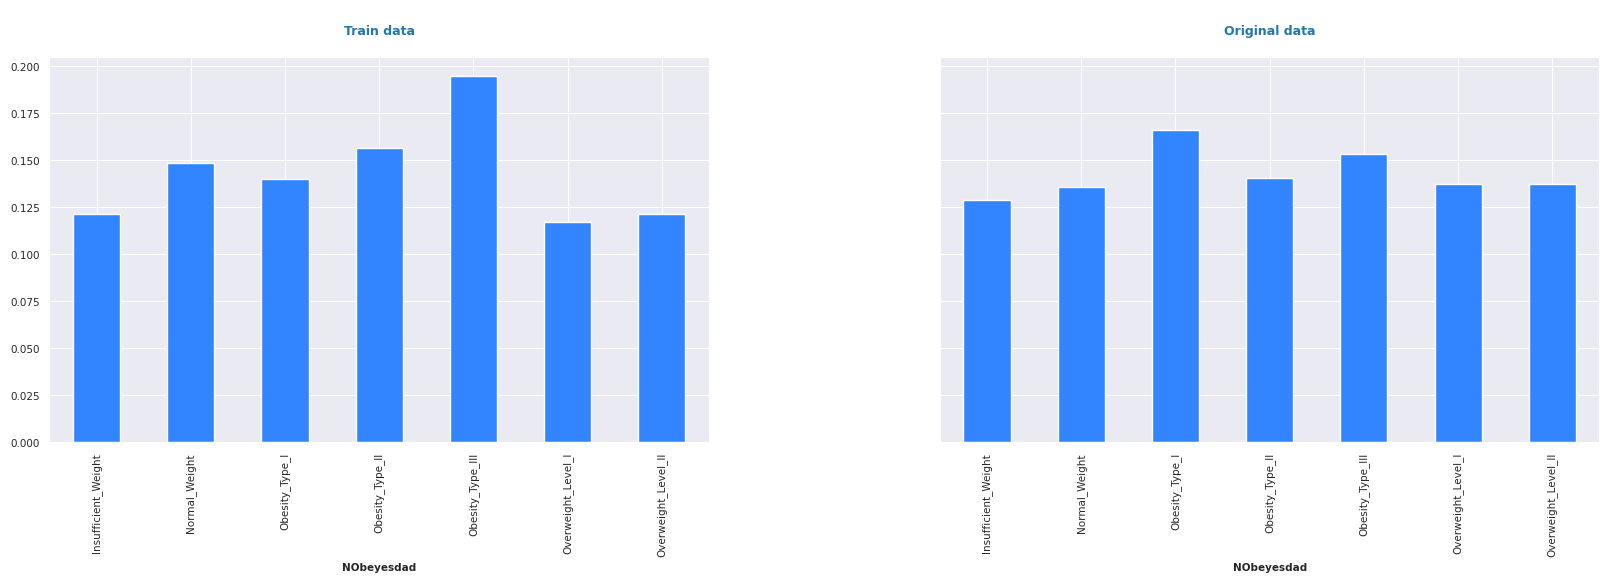


CPU times: user 636 ms, sys: 21.7 ms, total: 658 ms
Wall time: 683 ms


In [11]:
%%time 

if CFG.ftre_plots_req == "Y":
    fig, axes = plt.subplots(1,2, figsize = (20, 5), sharey = True, gridspec_kw = {'wspace': 0.35});
    
    for i, df in tqdm(enumerate([pp.train, pp.original]), "Target plot ---> "):
        ax= axes[i];
        a = df[CFG.target].value_counts(normalize = True);
        a.sort_index().plot.bar(color = '#3385ff', ax = ax);
        df_name = 'Train' if i == 0 else "Original";
        _ = ax.set_title(f"\n{df_name} data\n", **CFG.title_specs);
        
    plt.tight_layout();
    plt.show();
    
print();
collect();

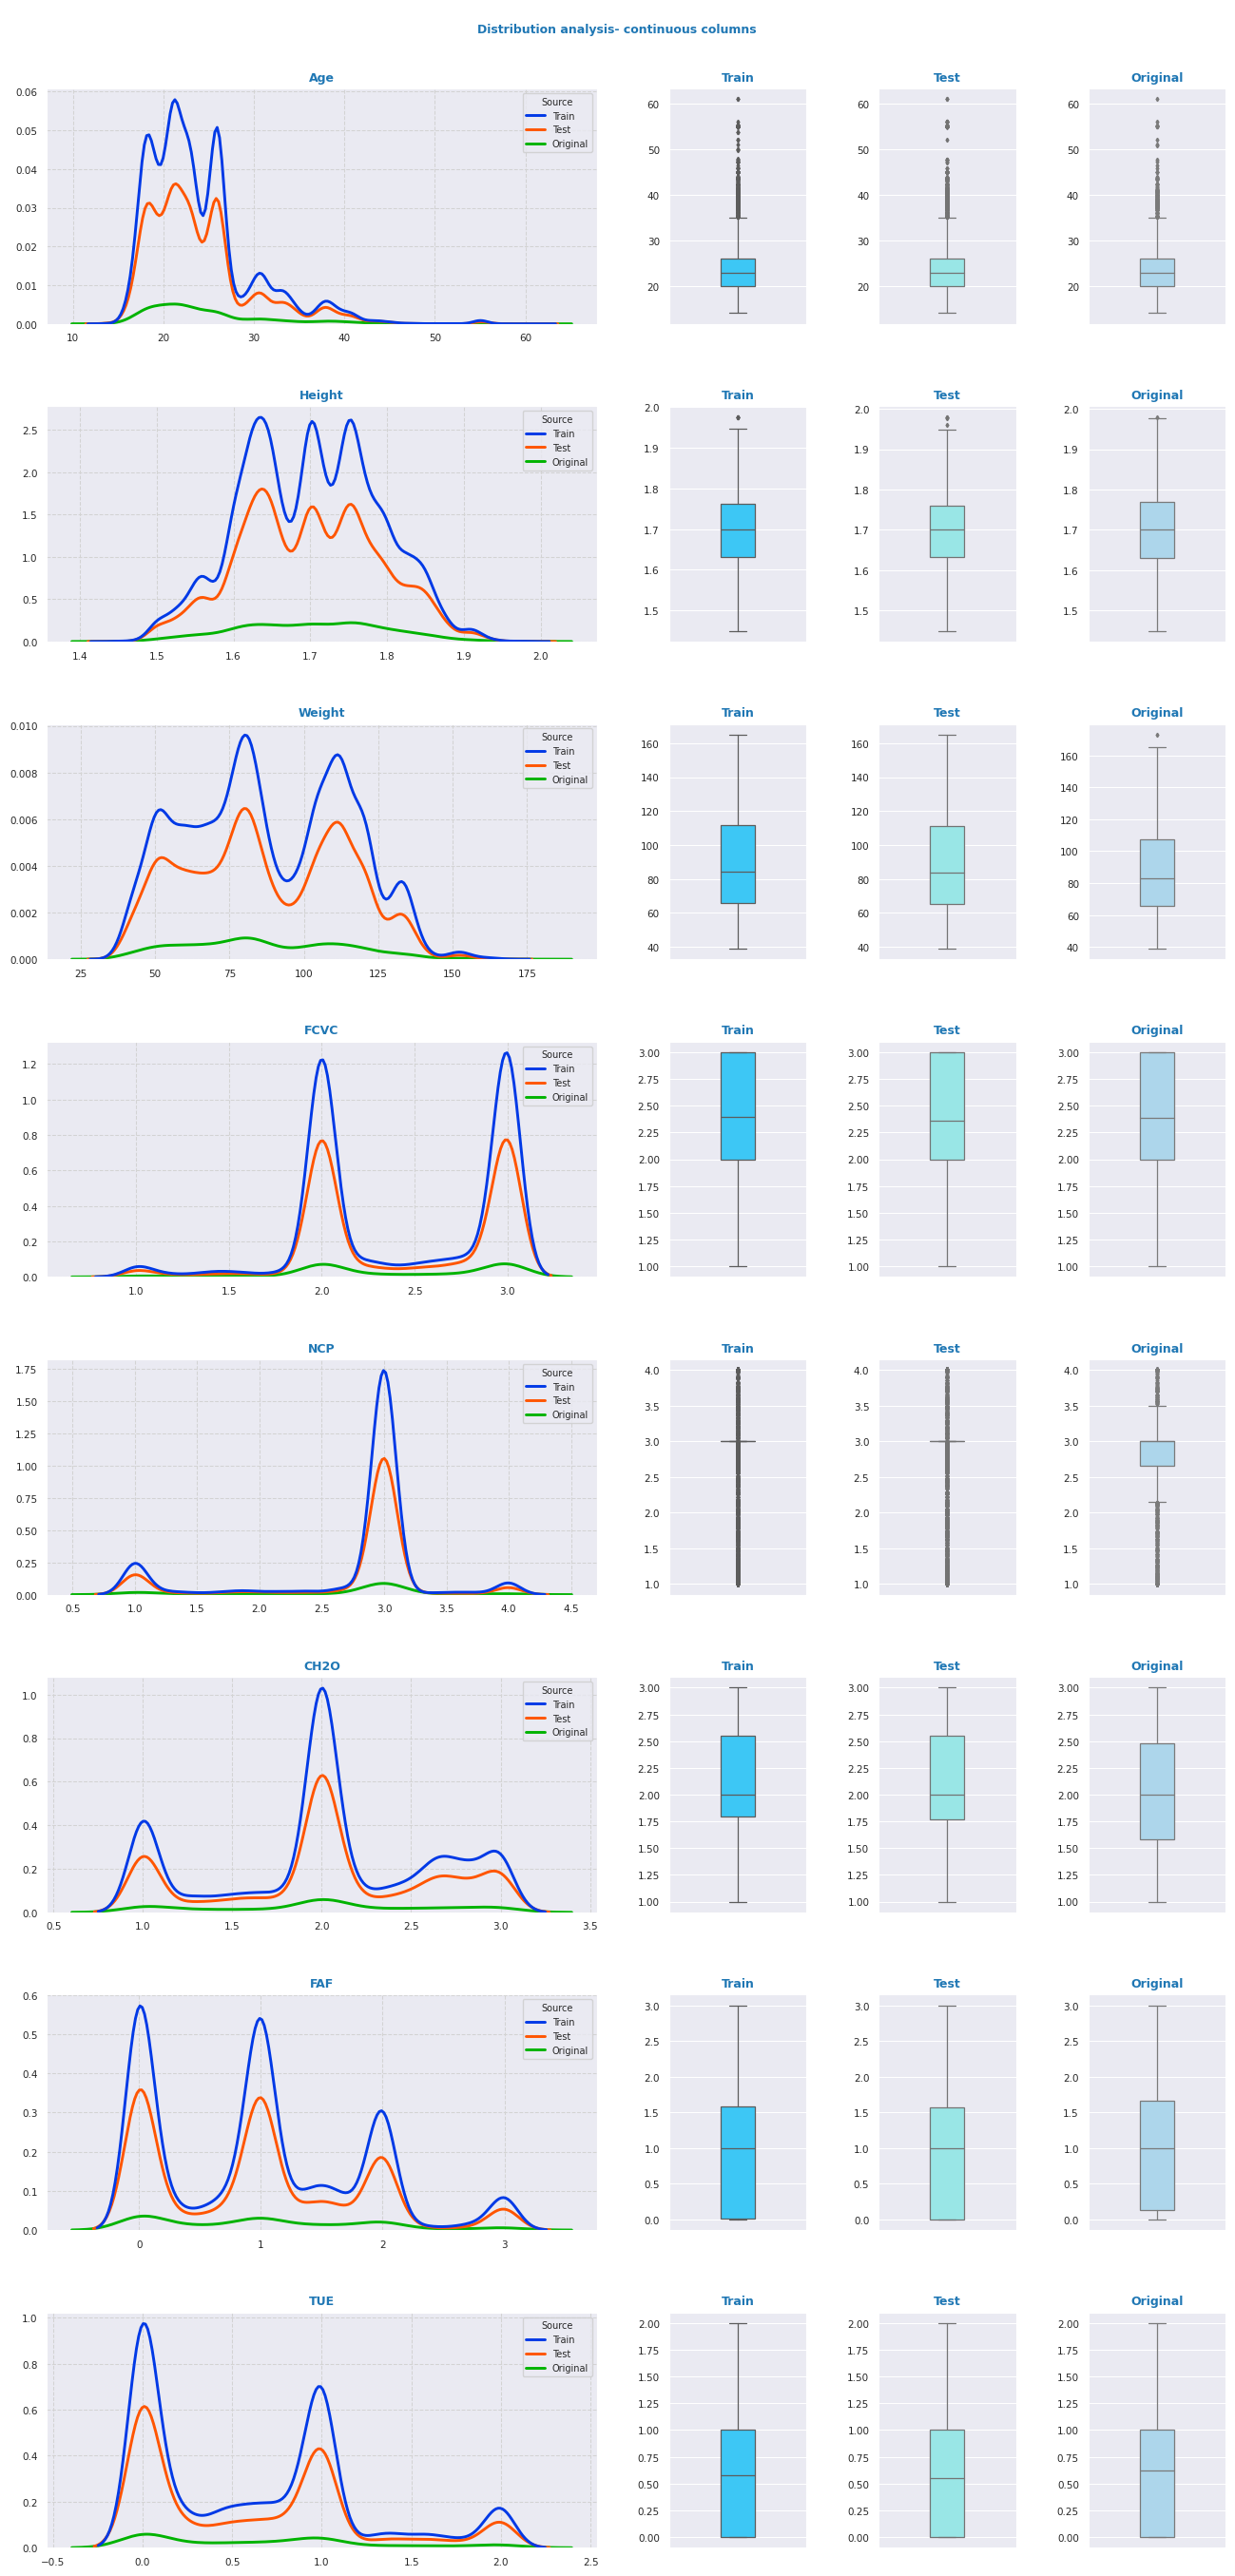


CPU times: user 12.3 s, sys: 4.86 s, total: 17.1 s
Wall time: 8.89 s


In [12]:
%%time 

if CFG.ftre_plots_req == "Y":
    df = pd.concat([pp.train[cont_cols].assign(Source = 'Train'), 
                    pp.test[cont_cols].assign(Source = 'Test'),
                    pp.original[cont_cols].assign(Source = "Original")
                   ], 
                   axis=0, ignore_index = True
                  );
    
    fig, axes = plt.subplots(len(cont_cols), 4 ,figsize = (16, len(cont_cols) * 4.2), 
                             gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20, 0.20]});
    
    for i,col in enumerate(cont_cols):
        ax = axes[i,0];
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                    palette = ['#0039e6', '#ff5500', '#00b300'], 
                    ax = ax, linewidth = 2.1
                   );
        ax.set_title(f"\n{col}", **CFG.title_specs);
        ax.grid(**CFG.grid_specs);
        ax.set(xlabel = '', ylabel = '');
        
        ax = axes[i,1];
        sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,
                    color = '#33ccff', saturation = 0.90, linewidth = 0.90, 
                    fliersize= 2.25,
                    ax = ax);
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Train", **CFG.title_specs);
        
        ax = axes[i,2];
        sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#80ffff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Test", **CFG.title_specs);
        
        ax = axes[i,3];
        sns.boxplot(data = df.loc[df.Source == 'Original', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#99ddff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Original", **CFG.title_specs);
              
    plt.suptitle(f"\nDistribution analysis- continuous columns\n", **CFG.title_specs, 
                 y = 0.905, x = 0.50
                );
    plt.tight_layout();
    plt.show();
    
print();
collect();

In [13]:
%%time 

# Calculating skewness across columns:-
skew_df = pd.DataFrame(index = cont_cols);
for col, df in {"Train": pp.train[cont_cols], 
                "Test": pp.test[cont_cols], 
                "Original": pp.original[cont_cols]}.items():   
    skew_df = \
    pd.concat([skew_df, 
               df.drop(columns = [CFG.target, "Source", "id"], errors = "ignore").skew()],
               axis=1).rename({0: col}, axis=1);

PrintColor(f"\nSkewness across independent features\n");
display(skew_df.transpose().style.format(precision = 2).background_gradient("Pastel2"));

collect();
print();


Skewness across independent features



,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Train,1.59,0.02,0.09,-0.36,-1.56,-0.21,0.51,0.67
Test,1.57,0.06,0.09,-0.34,-1.54,-0.20,0.53,0.70
Original,1.53,-0.01,0.26,-0.43,-1.11,-0.10,0.50,0.62



CPU times: user 163 ms, sys: 1.08 ms, total: 164 ms
Wall time: 162 ms


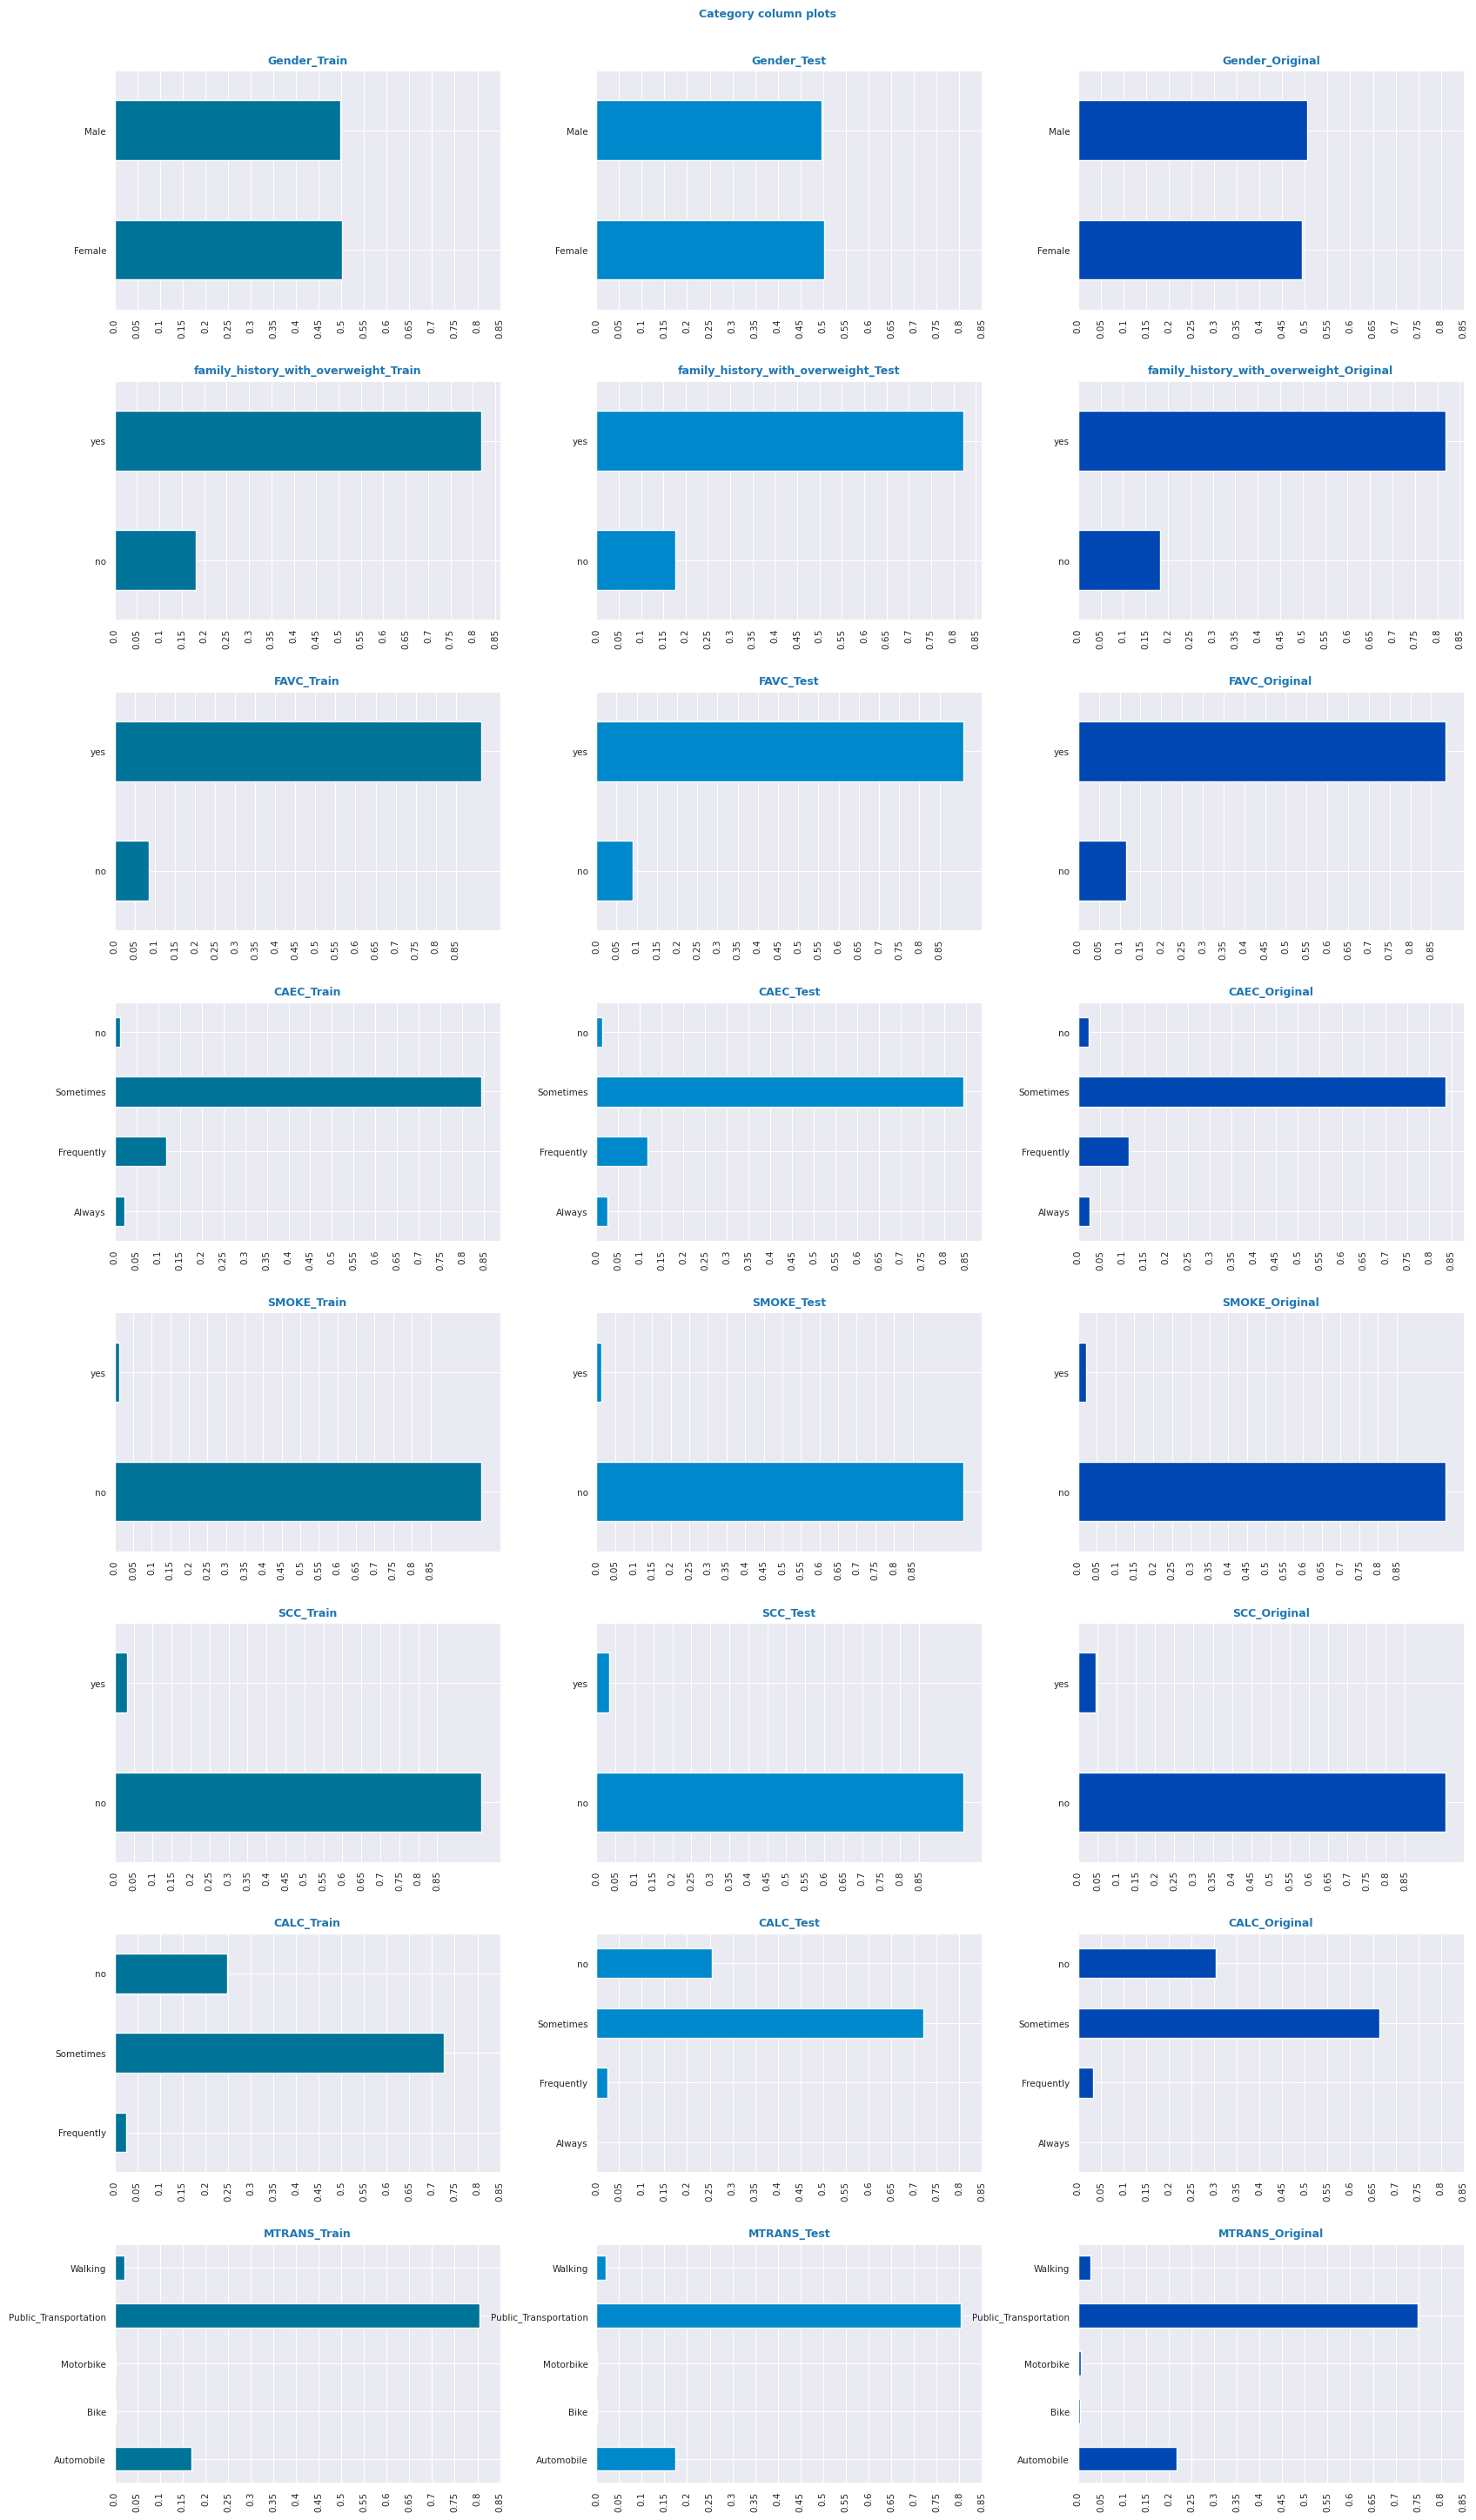


CPU times: user 6.96 s, sys: 87.1 ms, total: 7.05 s
Wall time: 7.04 s


In [14]:
%%time 

if CFG.ftre_plots_req == "Y" and cat_cols != []:
    fig, axes = plt.subplots(len(cat_cols), 3, figsize = (20, len(cat_cols)* 4.5), 
                             gridspec_kw = {'wspace': 0.25, 'hspace': 0.3});

    for i, col in enumerate(cat_cols):
        ax = axes[i, 0];
        a = pp.train[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#007399');
        ax.set_title(f"{col}_Train", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;

        ax = axes[i, 1];
        a = pp.test[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#0088cc');
        ax.set_title(f"{col}_Test", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;
        
        ax = axes[i, 2];
        a = pp.original[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#0047b3');
        ax.set_title(f"{col}_Original", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;       
    
    plt.suptitle(f"Category column plots", **CFG.title_specs, y= 0.90);
    plt.tight_layout();
    plt.show();
    
print();
collect();

In [15]:
%%time 

def MakeCorrPlot(df: pd.DataFrame, data_label:str, figsize = (30, 9)):
    """
    This function develops the correlation plots for the given dataset
    """;
    
    fig, axes = plt.subplots(1,2, figsize = figsize, gridspec_kw = {'hspace': 0.2, 'wspace': 0.1},
                             sharey = True
                            );
    
    for i, method in enumerate(['pearson', 'spearman']):
        corr_ = df.drop(columns = ['id', 'Source'], errors = 'ignore').corr(method = method);
        ax = axes[i];
        sns.heatmap(data = corr_,  
                    annot= True,
                    fmt= '.2f', 
                    cmap = 'Blues',
                    annot_kws= {'fontweight': 'bold','fontsize': 6.75}, 
                    linewidths= 1.5, 
                    linecolor='white', 
                    cbar= False, 
                    mask= np.triu(np.ones_like(corr_)),
                    ax= ax
                   );
        ax.set_title(f"\n{method.capitalize()} correlation- {data_label}\n", **CFG.title_specs);
        
    collect();
    print();

print();
collect();


CPU times: user 145 ms, sys: 900 µs, total: 146 ms
Wall time: 144 ms


In [16]:
%%time 

# Data transforms:-
class Xformer(TransformerMixin, BaseEstimator):
    """
    This class adds secondary features to the existing data using simple interactions
    """;
    
    def __init__(self): 
        self.sec_ftre_req = CFG.sec_ftre_req;
    
    def fit(self, X, y= None, **params):
        return self;
    
    @staticmethod
    def _reduce_mem(df: pd.DataFrame):
        "This method reduces memory for numeric columns in the dataframe";
        
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"];
        start_mem = df.memory_usage().sum() / 1024**2;
        
        for col in df.columns:
            col_type = df[col].dtypes
            
            if col_type in numerics:
                c_min = df[col].min();
                c_max = df[col].max();

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)  

        end_mem = df.memory_usage().sum() / 1024**2
    
        PrintColor(f"Start - end memory:- {start_mem:5.2f} - {end_mem:5.2f} Mb");
        return df;
    
    def transform(self, X, y= None, **params):
        """
        This method adds secondary features to the existing data
        It also encodes category columns manually
        Source- https://www.kaggle.com/competitions/playground-series-s4e2/discussion/472417
        """;
        
        df = X.copy().fillna(method = "ffill").fillna(method = "bfill"); 
        
        if self.sec_ftre_req == "Y":
            df["BMI"]     = df["Weight"] / df["Height"]**2;
            df["BMI_Grp"] = \
            np.select([df["BMI"] < 18.5, df["BMI"] < 25, df["BMI"] < 30, df["BMI"] < 35, df["BMI"] < 40],
                      [0,1,2,3,4], 5
                     ).astype(np.int8);
            
            df["BMIbyNCP"] = df["BMI"] / df["NCP"];
            df["BMIFAF"]   = (df["BMI"] * df["FAF"])/ 25.0;
            
        self.op_cols = df.columns;
        df = self._reduce_mem(df);
        return df;
    
    def get_feature_names_in(self, X, y=None, **params): 
        return self.ip_cols;    
    
    def get_feature_names_out(self, X, y=None, **params): 
        return self.op_cols;
    
collect();
print();


CPU times: user 132 ms, sys: 98 µs, total: 132 ms
Wall time: 131 ms


In [17]:
%%time

PrintColor(f"\n{'='* 20} Data transformation {'='* 20} \n");

ytrain = train[CFG.target];
Xtrain = train.drop(columns = [CFG.target]);
Xtest  = test.copy(deep = True);

PrintColor(f"\n---> Train data\n");
display(Xtrain.head(5).style.format(precision = 2));
PrintColor(f"\n---> Test data\n");
display(Xtest.head(5).style.format(precision = 2));

# Designing the data pipeline:-
myenc = \
ColumnTransformer(transformers = [("OE", OrdinalEncoder(), 
                                   ["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]
                                  ),
                                  ("OH", OneHotEncoder(use_cat_names = True), CFG.OH_cols)
                                 ],
                  verbose_feature_names_out  = False,
                  remainder = 'passthrough',
                 );

xform  = Pipeline(steps = [("E", myenc), ("S1", Xformer())]);  
Xtrain = xform.fit_transform(Xtrain, ytrain);
Xtest  = xform.transform(Xtest);
print();

# Checking the results:-
with np.printoptions(linewidth = 160):
    PrintColor(f"\n---> Train data columns after data pipeline\n");
    pprint(np.array(Xtrain.columns));

    PrintColor(f"\n---> Test data columns after data pipeline\n");
    pprint(np.array(Xtest.columns));
    PrintColor(f"\n---> Train-test shape after pipeline = {Xtrain.shape} {Xtest.shape}");

    PrintColor(f"\n---> Dropping duplicates in the train data");
    _ = pd.concat([Xtrain, ytrain], axis=1).drop_duplicates(subset = Xtrain.columns[0:-1].to_list());
    _.index = range(len(_));
    Xtrain, ytrain = _.drop(columns = [CFG.target]), _[CFG.target];
    del _;
    PrintColor(f"---> Train-test shape after duplicate removal = {Xtrain.shape} {Xtest.shape}");

print();
collect();


==================== Data transformation ==================== 


---> Train data



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Source
id,,,,,,,,,,,,,,,,,
0,Male,24.44,1.70,81.67,yes,yes,2.00,2.98,Sometimes,no,2.76,no,0.00,0.98,Sometimes,Public_Transportation,Competition
1,Female,18.00,1.56,57.00,yes,yes,2.00,3.00,Frequently,no,2.00,no,1.00,1.00,no,Automobile,Competition
2,Female,18.00,1.71,50.17,yes,yes,1.88,1.41,Sometimes,no,1.91,no,0.87,1.67,no,Public_Transportation,Competition
3,Female,20.95,1.71,131.27,yes,yes,3.00,3.00,Sometimes,no,1.67,no,1.47,0.78,Sometimes,Public_Transportation,Competition
4,Male,31.64,1.91,93.80,yes,yes,2.68,1.97,Sometimes,no,1.98,no,1.97,0.93,Sometimes,Public_Transportation,Competition



---> Test data



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Source
id,,,,,,,,,,,,,,,,,
20758,Male,26.90,1.85,120.64,yes,yes,2.94,3.00,Sometimes,no,2.83,no,0.86,0.00,Sometimes,Public_Transportation,Competition
20759,Female,21.00,1.60,66.00,yes,yes,2.00,1.00,Sometimes,no,3.00,no,1.00,0.00,Sometimes,Public_Transportation,Competition
20760,Female,26.00,1.64,111.60,yes,yes,3.00,3.00,Sometimes,no,2.62,no,0.00,0.25,Sometimes,Public_Transportation,Competition
20761,Male,20.98,1.55,103.67,yes,yes,2.00,2.98,Sometimes,no,2.79,no,0.09,0.00,Sometimes,Public_Transportation,Competition
20762,Female,26.00,1.63,104.84,yes,yes,3.00,3.00,Sometimes,no,2.65,no,0.00,0.74,Sometimes,Public_Transportation,Competition


Start - end memory:-  5.25 -  1.55 Mb
Start - end memory:-  3.29 -  1.04 Mb


---> Train data columns after data pipeline

array(['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'CAEC_Sometimes', 'CAEC_Frequently', 'CAEC_no', 'CAEC_Always', 'CALC_Sometimes',
       'CALC_no', 'CALC_Frequently', 'CALC_Always', 'MTRANS_Public_Transportation', 'MTRANS_Automobile', 'MTRANS_Walking', 'MTRANS_Motorbike', 'MTRANS_Bike',
       'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Source', 'BMI', 'BMI_Grp', 'BMIbyNCP', 'BMIFAF'], dtype=object)

---> Test data columns after data pipeline

array(['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'CAEC_Sometimes', 'CAEC_Frequently', 'CAEC_no', 'CAEC_Always', 'CALC_Sometimes',
       'CALC_no', 'CALC_Frequently', 'CALC_Always', 'MTRANS_Public_Transportation', 'MTRANS_Automobile', 'MTRANS_Walking', 'MTRANS_Motorbike', 'MTRANS_Bike',
       'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE

In [18]:
%%time 

# Shortlisting the duplicate data between train and test dataframes for post-processing:-
join_cols = Xtrain.columns[0:-1].to_list();

dups_df = \
Xtrain.\
reset_index(names = "id").\
assign(Label = "Train").\
merge(Xtest.reset_index().assign(Label = "Test"),
      how = "inner", on = join_cols, suffixes = ("_train", "_test")).\
drop(columns = join_cols).\
merge(ytrain, how = "inner", left_on = "id_train", right_index = True)\
[['id_train', 'id_test', CFG.target]].\
drop_duplicates(subset = ['id_test']);

del join_cols;

PrintColor(f"\n---> Train-test duplicate data glimpse- shape = {dups_df.shape}");
display(dups_df.head(10).style.format(precision = 3));
dups_df.to_csv(f"Duplicates.csv", index = None);

collect();
print();


---> Train-test duplicate data glimpse- shape = (30, 3)


,id_train,id_test,NObeyesdad
0,88,29195,Obesity_Type_III
1,88,31817,Obesity_Type_III
2,1691,21601,Obesity_Type_III
3,1691,24500,Obesity_Type_III
4,2783,28900,Obesity_Type_III
5,3031,23912,Obesity_Type_III
6,3324,22561,Obesity_Type_III
7,3324,32404,Obesity_Type_III
8,4323,27557,Obesity_Type_III
9,4532,24649,Obesity_Type_III



CPU times: user 194 ms, sys: 1.44 ms, total: 196 ms
Wall time: 198 ms





CPU times: user 3.14 s, sys: 58.9 ms, total: 3.2 s
Wall time: 3.19 s


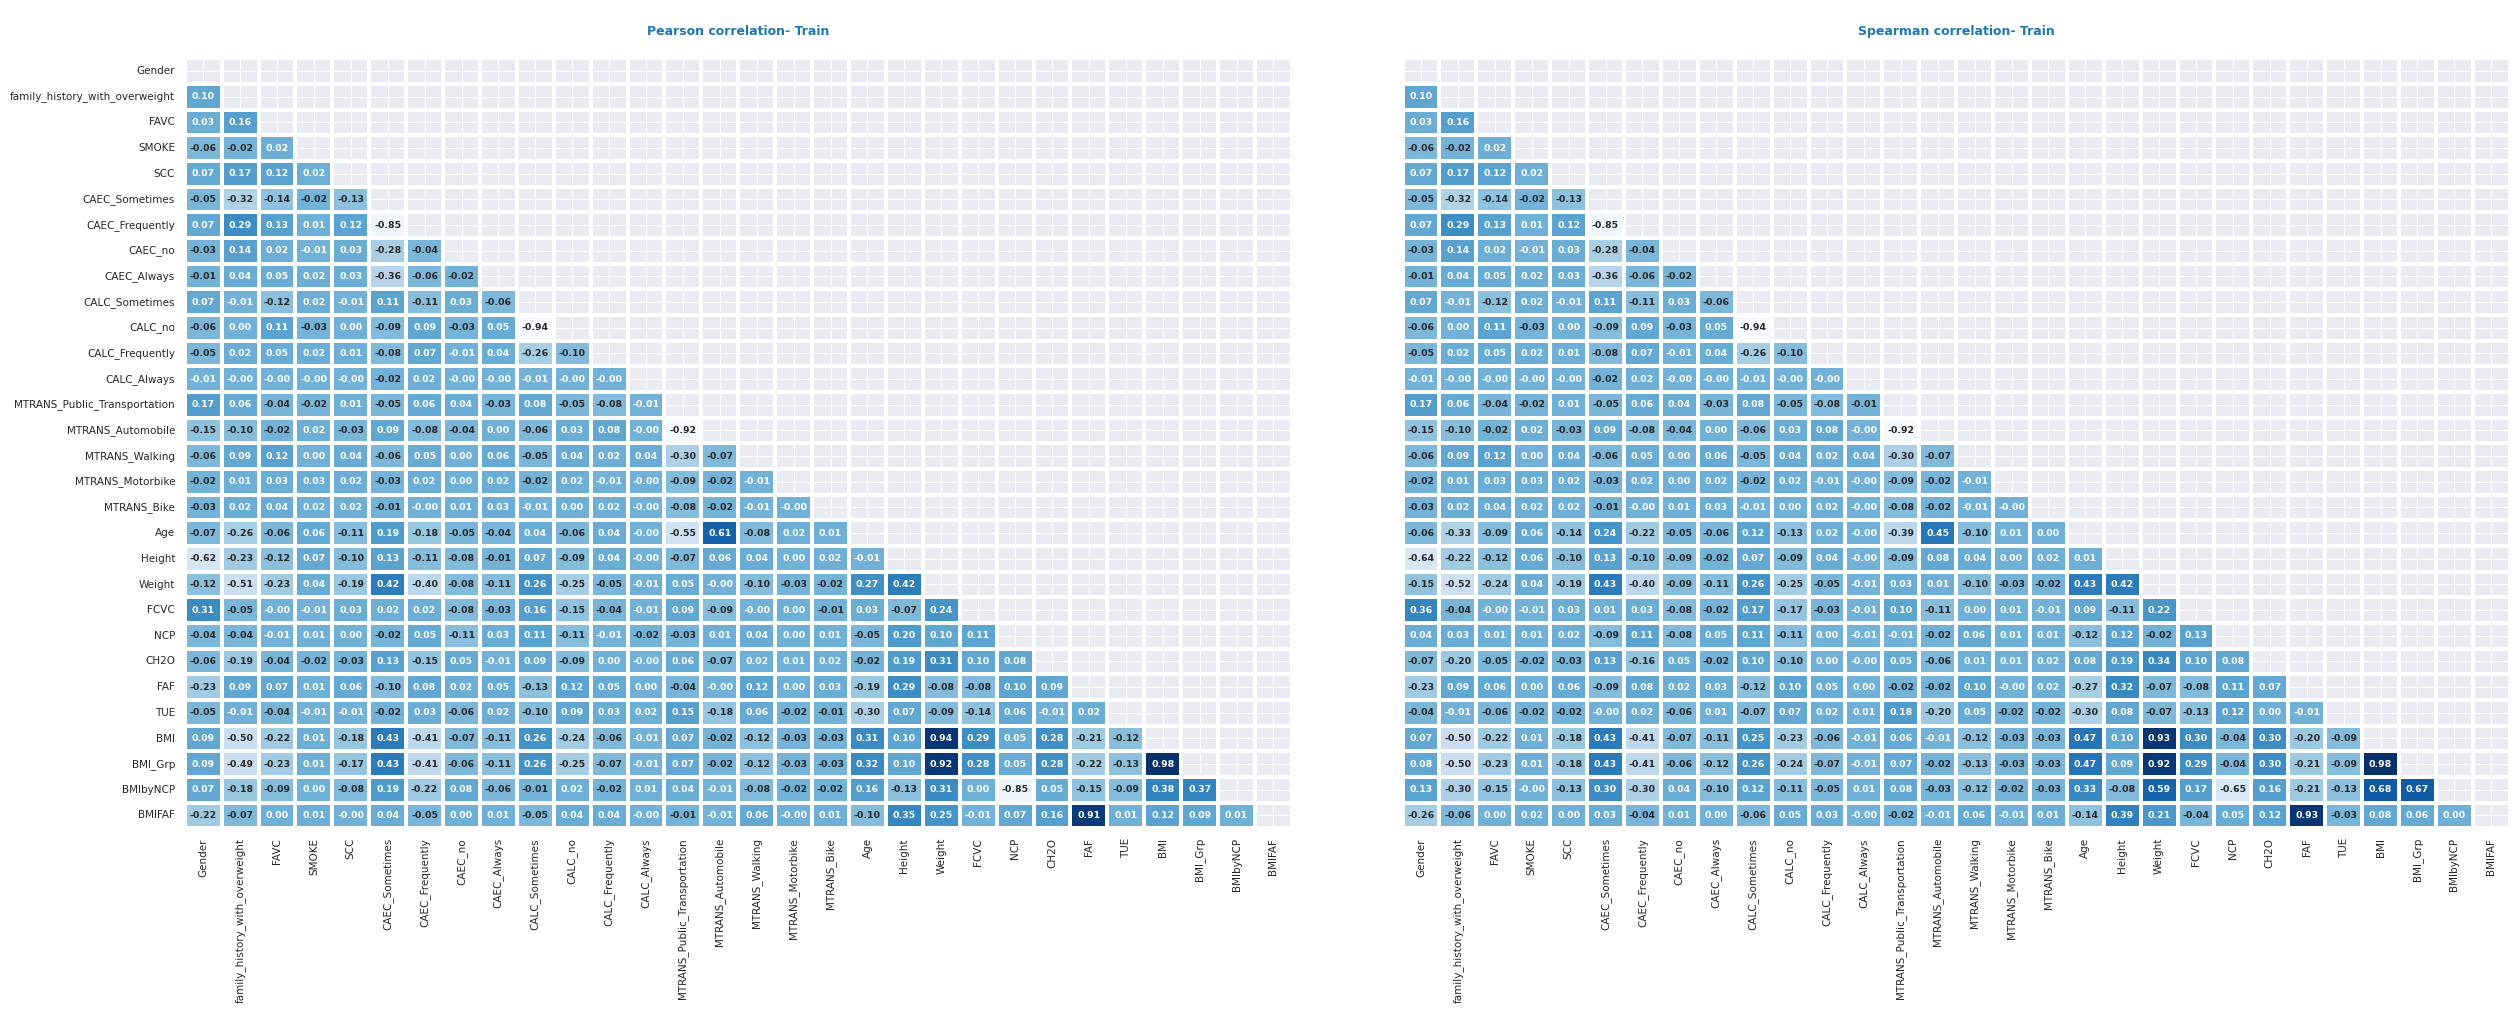

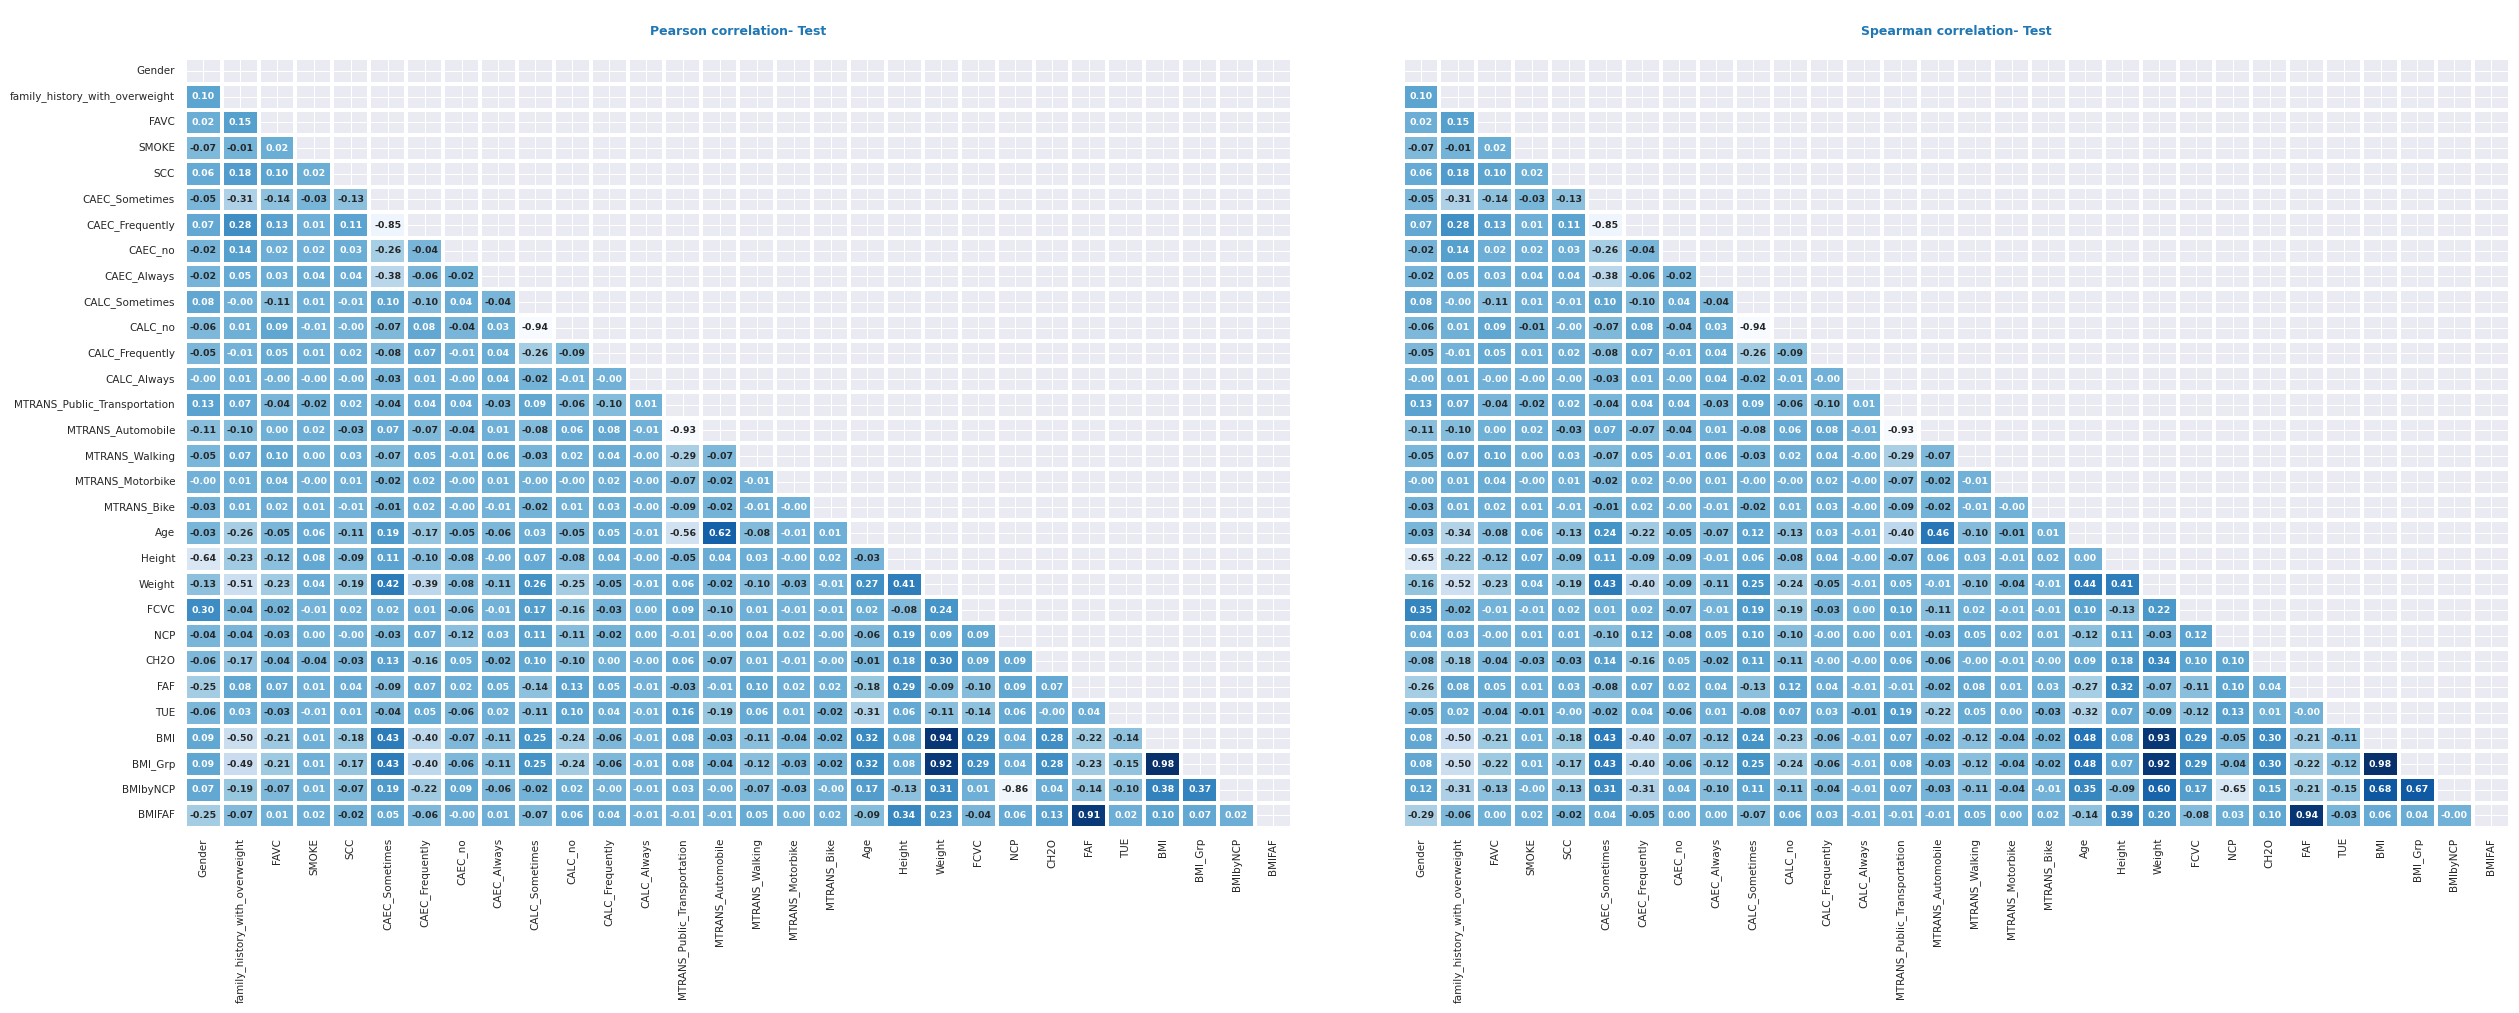

In [19]:
%%time 

# Implementing correlation analysis:-
if CFG.ftre_imp_req == "Y":
    MakeCorrPlot(df = Xtrain, data_label = "Train", figsize = (30,10));
    MakeCorrPlot(df = Xtest,  data_label = "Test",  figsize = (30,10));
    
print();
collect();

In [20]:
%%time 

class OptunaWeights:
    """
    This is the Optuna ensemble class-
    Source- https://www.kaggle.com/code/arunklenin/ps3e26-cirrhosis-survial-prediction-multiclass
    """;
    
    def __init__(self):
        self.study        = None;
        self.weights      = None;
        self.random_state = CFG.state;
        self.n_trials     = CFG.ntrials;
        self.direction    = CFG.metric_obj;
        
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the ensemble
        """;
        return accuracy_score(ytrue, ypred);

    def _objective(self, trial, y_true, y_preds):
        """
        This method defines the objective function for the ensemble
        """;
        
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]

        # Calculating the weighted prediction:-
        weighted_pred  = np.average(np.array(y_preds), axis=0, weights = weights);
        weighted_pred  = weighted_pred / weighted_pred.sum(axis=1, keepdims = True);
        score          = self.ScoreMetric(y_true, np.argmax(weighted_pred, axis=1));
        return score;

    def fit(self, y_true, y_preds):
        "This method fits the Optuna objective on the fold level data";
        
        optuna.logging.set_verbosity = optuna.logging.ERROR;
        self.study = \
        optuna.create_study(sampler    = TPESampler(seed = self.random_state), 
                            pruner     = HyperbandPruner(),
                            study_name = "OptunaWeights", 
                            direction  = self.direction,
                           );
        
        obj = partial(self._objective, y_true = y_true, y_preds = y_preds);
        self.study.optimize(obj, n_trials = self.n_trials);
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))];
        clear_output();

    def predict(self, y_preds):
        "This method predicts using the fitted Optuna objective";
        
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds), axis=0, weights = self.weights);
        return weighted_pred;

    def fit_predict(self, y_true, y_preds):
        """
        This method fits the Optuna objective on the fold data, then predicts the test set
        """;
        self.fit(y_true, y_preds);
        return self.predict(y_preds);
    
    def weights(self):
        return self.weights;
    
print();
collect();


CPU times: user 241 ms, sys: 1.82 ms, total: 243 ms
Wall time: 241 ms


In [21]:
%%time 

class MdlDeveloper(CFG):
    """
    This class implements the training pipeline elements-
    1. Initializes the Model predictions
    2. Trains and infers models
    3. Returns the OOF and model test set predictions
    """;
    
    def __init__(self, Xtrain, ytrain, Xtest, sel_cols, cat_cols, **kwarg):
        """
        In this method, we initialize the below-
        1. Train-test data, selected columns
        2. Metric, custom scorer, model and cv object
        3. Output tables for score and predictions
        
        Note:-
        OOF_Preds contains the ensemble OOF predictions per fold averaged across all folds
        """;
        
        self.Xtrain      = Xtrain;
        self.Ytrain      = ytrain;
        self.Xtest       = Xtest;
        self.sel_cols    = sel_cols;
        self.cat_cols    = cat_cols;

        self.tgt_cat     = CFG.tgt_mapper;
        self.tgt_cat_inv = {i:j for j, i in CFG.tgt_mapper.items()};
        self.nclass      = len(CFG.tgt_mapper.keys());
        self.ytrain      = self.Ytrain.map(self.tgt_cat).astype(np.uint8);
        
        self._DefineModels();
        self.cv          = self.all_cv[CFG.mdlcv_mthd];
        self.methods     = list(self.Mdl_Master.keys());
        self.OOF_Preds   = pd.DataFrame(columns = [f"Status_{k}" for k in self.tgt_cat.keys()]);
        self.Mdl_Preds   = pd.DataFrame(columns = [f"Status_{k}" for k in self.tgt_cat.keys()]);
        self.Scores      = pd.DataFrame(columns = self.methods, index = range(CFG.n_splits * CFG.n_repeats));
        self.TrainScores = pd.DataFrame(columns = self.methods, index = range(CFG.n_splits * CFG.n_repeats));
        
        self.mdlscorer   = make_scorer(self.ScoreMetric, 
                                       greater_is_better = False if self.metric_obj == "minimize" else True,
                                       needs_proba       = True,
                                       needs_threshold   = False,
                                      );  
        self.y_grp = self.ytrain;

        PrintColor(f"\n---> Selected model options-");
        pprint(self.methods, depth = 1, width = 100, indent = 5);
              
    def _DefineModels(self):
        """
        This method initiliazes models for the analysis
        It also initializes the CV methods and class-weights that could be tuned going ahead.
        """;
        
        # Commonly used CV strategies for later usage:-
        self.all_cv = \
        {'KF'  : KFold(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state),
         'RKF' : RKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'RSKF': RSKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'SKF' : SKF(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state)
        };
               
        self.Mdl_Master = \
        {                      
         'XGB1C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'multi:softprob',
                          'eval_metric'           : "auc",
                          'num_class'             : self.nclass,
                          'random_state'          : CFG.state,
                          'colsample_bytree'      : 0.25,
                          'learning_rate'         : 0.07,
                          'max_depth'             : 6,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.09,
                          'reg_lambda'            : 0.70,
                          'min_child_weight'      : 12,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          'class_weight'          : "balanced",
                         }
                      ),
            
         'XGB2C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'multi:softprob',
                          'eval_metric'           : "auc",
                          'num_class'             : self.nclass,
                          'random_state'          : CFG.state,
                          'colsample_bytree'      : 0.40,
                          'learning_rate'         : 0.055,
                          'max_depth'             : 7,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.12,
                          'reg_lambda'            : 0.8,
                          'min_child_weight'      : 15,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                         }
                      ),

         'XGB3C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'multi:softprob',
                          'eval_metric'           : "auc",
                          'num_class'             : self.nclass,
                          'random_state'          : CFG.state,
                          'colsample_bytree'      : 0.5,
                          'learning_rate'         : 0.04,
                          'max_depth'             : 7,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.2,
                          'reg_lambda'            : 0.6,
                          'min_child_weight'      : 16,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                         }
                      ),
            
         'XGB4C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'multi:softprob',
                          'eval_metric'           : "auc",
                          'num_class'             : self.nclass,
                          'random_state'          : CFG.state,
                          'colsample_bytree'      : 0.80,
                          'learning_rate'         : 0.06,
                          'max_depth'             : 7,
                          'n_estimators'          : 2000,                         
                          'reg_alpha'             : 0.005,
                          'reg_lambda'            : 0.95,
                          'min_child_weight'      : 16,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          'class_weight'          : "balanced",
                         }
                      ),
              
         'LGBM1C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.56,
                           'subsample'           : 0.35,
                           'learning_rate'       : 0.035,
                           'max_depth'           : 6,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 110,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1,
                           'categorical_feature' : [f"name: {col}" for col in self.cat_cols],
                          }
                       ),
            
         'LGBM2C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'data_sample_strategy': "goss",
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.20,
                           'subsample'           : 0.25,
                           'learning_rate'       : 0.04,
                           'max_depth'           : 8,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 100, 
                           'reg_alpha'           : 0.15,
                           'reg_lambda'          : 0.90,
                           'verbosity'           : -1,
                           'categorical_feature' : [f"name: {col}" for col in self.cat_cols],
                          }
                       ),
            
         'LGBM3C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.45,
                           'subsample'           : 0.45,
                           'learning_rate'       : 0.05,
                           'max_depth'           : 7,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 90, 
                           'reg_alpha'           : 0.05,
                           'reg_lambda'          : 0.95,
                           'verbosity'           : -1,
                           'categorical_feature' : [f"name: {col}" for col in self.cat_cols],
                          }
                       ), 
            
         'LGBM4C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.55,
                           'subsample'           : 0.55,
                           'learning_rate'       : 0.06,
                           'max_depth'           : 6,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 85, 
                           'reg_alpha'           : 0.08,
                           'reg_lambda'          : 0.995,
                           'verbosity'           : -1,
                           'categorical_feature' : [f"name: {col}" for col in self.cat_cols],
                           'class_weight'        : "balanced",
                          }
                       ),
            
          "CB1C" : CBC(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
                          'objective'           : 'MultiClass',
                          'eval_metric'         : "Accuracy",
                          'bagging_temperature' : 0.1,
                          'colsample_bylevel'   : 0.88,
                          'iterations'          : 1000,
                          'learning_rate'       : 0.06,
                          'od_wait'             : 12,
                          'max_depth'           : 7,
                          'l2_leaf_reg'         : 1.75,
                          'min_data_in_leaf'    : 15,
                          'random_strength'     : 0.1, 
                          'max_bin'             : 100,
                          'verbose'             : 0,
                          'use_best_model'      : True,
                         }
                      ),
            
          "CB2C" : CBC(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
                          'objective'           : 'MultiClass',
                          'eval_metric'         : "Accuracy",
                          'bagging_temperature' : 0.4,
                          'colsample_bylevel'   : 0.65,
                          'iterations'          : 1000,
                          'learning_rate'       : 0.055,
                          'od_wait'             : 12,
                          'max_depth'           : 8,
                          'l2_leaf_reg'         : 3.5,
                          'min_data_in_leaf'    : 12,
                          'random_strength'     : 0.175, 
                          'max_bin'             : 100,
                          'verbose'             : 0,
                          'use_best_model'      : True,
                          "grow_policy"         : "Lossguide",
                         }
                      ),            
            
        };
        return self;
    
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the competition
        """;
        return accuracy_score(ytrue, ypred);
    
    def PostProcessPred(self, ypred):
        """
        This is an optional post-processing method
        """;
        return ypred;
    
    def TrainMdl(self, test_preds_req: str = "Y"):
        """
        This method trains and infers from the model suite and returns the predictions and scores
        It optionally predicts the test set too, if desired by the user
        """;

        # Initializing I-O:- 
        X,y, Xt    = self.Xtrain[self.sel_cols], self.ytrain.copy(deep = True), self.Xtest[self.sel_cols];
        cols_drop  = ['Source', "id"];
        ens        = OptunaWeights();
        
        # Making CV folds:-        
        for fold_nb, (train_idx, dev_idx) in tqdm(enumerate(self.cv.split(X, self.y_grp))):
            Xtr  = X.iloc[train_idx].drop(columns = cols_drop, errors = 'ignore');  
            Xdev = X.iloc[dev_idx].loc[X.Source == "Competition"].drop(columns = cols_drop, errors = 'ignore'); 
            
            ytr  = y.loc[y.index.isin(Xtr.index)];
            ydev = y.loc[y.index.isin(Xdev.index)];
                   
            # Initializing the OOF and test set predictions:-            
            oof_preds, mdl_preds = [], [];
            
            PrintColor(f"\n{'=' * 5} FOLD {fold_nb + 1} {'=' * 5}\n");
            # Initializing models across methods:-
            for method in tqdm(self.methods):
                model = Pipeline(steps = [("M", self.Mdl_Master.get(method))]); 

                # Fitting the model:-          
                if "CB" in method:    
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__verbose = 0,
                              M__early_stopping_rounds = CFG.nbrnd_erly_stp,
                              M__cat_features = self.cat_cols
                             ); 

                elif "LGBM" in method:
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__callbacks = [log_evaluation(0), 
                                              early_stopping(stopping_rounds = CFG.nbrnd_erly_stp, 
                                                             verbose = False,),
                                             ],
                             ); 

                elif "XGB" in method:
                     model.fit(Xtr, ytr, 
                               M__eval_set = [(Xdev, ydev)], 
                               M__verbose  = 0,
                              );            

                else: 
                    model.fit(Xtr, ytr);

                # Collecting predictions and scores and post-processing OOF based on model method:-
                dev_preds   = model.predict_proba(Xdev);
                train_preds = model.predict_proba(Xtr);
                oof_preds.append(dev_preds);
            
                if test_preds_req == "Y": 
                    test_preds = model.predict_proba(Xt.drop(columns = cols_drop, errors = "ignore"));
                    mdl_preds.append(test_preds);
                    del test_preds;
            
                tr_score = self.ScoreMetric(ytr.values.flatten(),np.argmax(train_preds, axis=1));
                score    = self.ScoreMetric(ydev.values.flatten(),np.argmax(dev_preds, axis=1));
                
                num_space = 3 if fold_nb <= 9 else 2;
                PrintColor(f"OOF = {score:.5f} | Train = {tr_score:.5f} | {method}",
                           color = Fore.CYAN
                          );
                del num_space;
            
                # Integrating the predictions and scores:-               
                self.Scores.at[fold_nb, method]      = np.round(score, decimals= 6);
                self.TrainScores.at[fold_nb, method] = np.round(tr_score, decimals= 6);
                del dev_preds;
                
            # Ensembling the predictions:-
            ens.fit(ydev, oof_preds);
            self.OOF_Preds = \
            pd.concat([self.OOF_Preds,
                       pd.DataFrame(ens.predict(oof_preds), index = Xdev.index, columns = self.OOF_Preds.columns)],
                      axis = 0, ignore_index = False
                     );
            
            if test_preds_req == "Y": 
                self.Mdl_Preds = \
                pd.concat([self.Mdl_Preds,
                           pd.DataFrame(ens.predict(mdl_preds), index = self.Xtest.index, columns = self.Mdl_Preds.columns)],
                          axis = 0, ignore_index = False
                         );
                
        # Averaging the predictions after all folds:-       
        self.OOF_Preds = self.OOF_Preds.groupby(level = 0).mean();
        if test_preds_req == "Y": 
            self.Mdl_Preds = self.Mdl_Preds.groupby(level = 0).mean();
            
        return self.OOF_Preds, self.Mdl_Preds, self.Scores, self.TrainScores;
    
    def DisplayAdjTbl(self, *args):
        """
        This function displays pandas tables in an adjacent manner, sourced from the below link-
        https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
        """;

        html_str = '';
        for df in args:
            html_str += df.to_html();
        display_html(html_str.replace('table','table style="display:inline"'),raw=True);
         
    def DisplayScores(self):
        "This method displays the scores and their means";
        
        args = \
        [self.Scores.style.format(precision = 5).\
         background_gradient(cmap = "Pastel2", subset = self.methods).\
         set_caption(f"\nOOF scores across methods and folds\n"),
         
         self.TrainScores.style.format(precision = 5).\
         background_gradient(cmap = "Pastel2", subset = self.methods).\
         set_caption(f"\nTrain scores across methods and folds\n")
        ];
        
        PrintColor(f"\n---> OOF score across all methods and folds\n",color = Fore.LIGHTMAGENTA_EX);
        self.DisplayAdjTbl(*args);
        
        args = \
        [self.Scores.mean().to_frame().transpose().style.format(precision = 5).\
         background_gradient(cmap = "icefire", subset = self.methods, axis=1).\
         set_caption(f"\nOOF scores across methods and folds\n"),
         
         self.TrainScores.mean().to_frame().transpose().style.format(precision = 5).\
         background_gradient(cmap = "icefire", subset = self.methods, axis=1).\
         set_caption(f"\nTrain scores across methods and folds\n")
        ]; 
        
        PrintColor(f"\n---> Mean score across all methods and folds\n",color = Fore.LIGHTMAGENTA_EX);
        self.DisplayAdjTbl(*args);
        
        PrintColor(f"\n---> Mean score across all methods and folds = {np.mean(np.ravel(Scores)):.5f}\n",
                   color = Fore.MAGENTA
                  );
        collect();
        
    def MakePseudoLbl(self, cutoff: float, **kwarg):
        """
        This method makes pseudo-labels using confident test set predictions to add to the training data
        """;
        
        # Locating confident test-set predictions:-        
        df         = self.Mdl_Preds.loc[np.amax(self.Mdl_Preds, axis=1) >= cutoff];
        df.columns = list(self.tgt_cat.keys());
        PrintColor(f"---> Pseudo Label additions from test set = {df.shape[0]:,.0f}", color = Fore.RED);
        
        #  Integrating new Xtrain and ytrain based on pseudo-labels:-       
        new_ytrain       = pd.concat([self.Ytrain, df.idxmax(axis=1)], 
                                     axis=0, ignore_index = True
                                    );
        new_ytrain.index = range(len(new_ytrain));
        new_Xtrain       = pd.concat([self.Xtrain, self.Xtest.loc[df.index]], axis=0, ignore_index = True);
        new_Xtrain.index = range(len(new_Xtrain));
        
        #  Verifying the additions:-
        PrintColor(f"---> Revised train set shapes after pseudo labels = {new_Xtrain.shape} {new_ytrain.shape}");
        return new_Xtrain, new_ytrain;
              
print();
collect();


CPU times: user 151 ms, sys: 1.86 ms, total: 153 ms
Wall time: 152 ms


In [22]:
%%time

if CFG.ML == "Y":
    sel_cols = Xtrain.columns;
    PrintColor(f"\n---> Selected model columns");
    with np.printoptions(linewidth = 150):
        print(np.array(sel_cols));
        
    PrintColor(f"\n---> Selected categorical columns");
    cat_ftre = [];
    for c in sel_cols:
        for col in cat_cols:
            if c.startswith(col):
                cat_ftre.append(c);

    with np.printoptions(linewidth = 150):
        print(np.array(cat_ftre));

print();
collect();


---> Selected model columns
['Gender' 'family_history_with_overweight' 'FAVC' 'SMOKE' 'SCC' 'CAEC_Sometimes' 'CAEC_Frequently' 'CAEC_no' 'CAEC_Always' 'CALC_Sometimes' 'CALC_no'
 'CALC_Frequently' 'CALC_Always' 'MTRANS_Public_Transportation' 'MTRANS_Automobile' 'MTRANS_Walking' 'MTRANS_Motorbike' 'MTRANS_Bike' 'Age' 'Height'
 'Weight' 'FCVC' 'NCP' 'CH2O' 'FAF' 'TUE' 'Source' 'BMI' 'BMI_Grp' 'BMIbyNCP' 'BMIFAF']

---> Selected categorical columns
['Gender' 'family_history_with_overweight' 'FAVC' 'SMOKE' 'SCC' 'CAEC_Sometimes' 'CAEC_Frequently' 'CAEC_no' 'CAEC_Always' 'CALC_Sometimes' 'CALC_no'
 'CALC_Frequently' 'CALC_Always' 'MTRANS_Public_Transportation' 'MTRANS_Automobile' 'MTRANS_Walking' 'MTRANS_Motorbike' 'MTRANS_Bike']

CPU times: user 130 ms, sys: 12 µs, total: 130 ms
Wall time: 130 ms


In [23]:
%%time 

if CFG.ML == "Y":
    # Training the models with a CV analysis:-  
    md = MdlDeveloper(Xtrain, ytrain, Xtest, sel_cols = sel_cols, cat_cols = cat_ftre);
    OOF_Preds, Mdl_Preds, Scores, TrainScores = \
    md.TrainMdl(test_preds_req = "Y");
    
    PrintColor(f"\n{'=' * 20} ML MODELS TRAINING AND CV {'=' * 20}\n", color = Fore.MAGENTA);
    md.DisplayScores();
    collect();
    
print();
collect();


==================== ML MODELS TRAINING AND CV ====================


---> OOF score across all methods and folds



,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C
0,0.90485,0.90533,0.90485,0.90533,0.90509,0.90271,0.90580,0.90723,0.90675,0.90271
1,0.90282,0.90330,0.90306,0.90282,0.90451,0.89896,0.90113,0.90258,0.90065,0.90113
2,0.91224,0.91078,0.90956,0.90931,0.91053,0.90322,0.91078,0.91004,0.90151,0.89907
3,0.90280,0.90474,0.90401,0.90063,0.90353,0.90014,0.90135,0.90256,0.90014,0.89700
4,0.91663,0.91855,0.91614,0.91639,0.91470,0.91783,0.91711,0.91566,0.91229,0.91277
,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C
0,0.95608,0.95318,0.95504,0.94984,0.95509,0.97059,0.96484,0.95925,0.94206,0.92782
1,0.95006,0.95280,0.95033,0.94874,0.95811,0.96369,0.96200,0.95143,0.94108,0.93166
2,0.95614,0.95734,0.96128,0.95520,0.96019,0.97202,0.96720,0.96161,0.93730,0.92421
3,0.94715,0.94869,0.94677,0.95017,0.95783,0.96320,0.96117,0.95296,0.93730,0.92437



---> Mean score across all methods and folds



,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C
0,0.90787,0.90854,0.90753,0.90690,0.90767,0.90457,0.90723,0.90762,0.90427,0.90254
,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C
0,0.95252,0.95200,0.95215,0.95359,0.95737,0.96926,0.96438,0.95626,0.94057,0.93045



---> Mean score across all methods and folds = 0.90647


CPU times: user 25min 2s, sys: 28.6 s, total: 25min 31s
Wall time: 8min 37s


In [24]:
%%time 

if CFG.ML == "Y" and CFG.pseudo_lbl_req == "Y":
    Xtrain, ytrain = md.MakePseudoLbl(cutoff = CFG.pseudolbl_up);
    
    # Re-initializing the developer class with the new training set:-  
    md = MdlDeveloper(Xtrain, ytrain, Xtest, sel_cols = sel_cols, cat_cols = cat_ftre);
    OOF_Preds, Mdl_Preds, Scores, TrainScores = md.TrainMdl(test_preds_req = "Y");
    
    PrintColor(f"\n{'=' * 20} ML MODELS TRAINING AND CV AFTER PSEUDO-LABELS {'=' * 20}\n", 
               color = Fore.MAGENTA
              );
    md.DisplayScores();
    collect();    
    
else:
    PrintColor(f"---> Pseudo Labels are not needed", Fore.RED);

print();
collect();

---> Pseudo Labels are not needed

CPU times: user 125 ms, sys: 965 µs, total: 126 ms
Wall time: 125 ms
